In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.densenet import preprocess_input

In [4]:
batch_size = 16
img_height = 224
img_width = 224

In [5]:
import sys
sys.path.insert(0, "D:\ISEN\M1\Projet M1\KimiaNet\Scripts")
import KimiaNet_AutoEncoder as Kn

In [4]:
autoencoder = Kn.KimiaNetAutoencoder()

In [5]:
autoencoder.freeze_encoder()

In [6]:
autoencoder.compile()

In [7]:
autoencoder.model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 28, 28, 128  4847168     ['input_1[0][0]']                
                                ),                                                                
                                 (None, 14, 14, 256                                               
                                ),                                                                
                                 (None, 7, 7, 512)]                                     

In [6]:
data_dir = "D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE"
data_dir = pathlib.Path(data_dir)

In [7]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)

In [8]:
image_count = len(list_ds)
print(image_count)

30007


In [9]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

24006
6001


In [11]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [12]:
def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, img

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [24]:
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds
#
# train_ds = configure_for_performance(train_ds)
# val_ds = configure_for_performance(val_ds)

In [25]:
# ia.seed(1)
# seq = iaa.Sequential([
#     iaa.Sometimes(
#         0.4,
#         iaa.GaussianBlur(sigma=(0, 2))
#     ),
#     iaa.Sometimes(
#         0.7,
#         iaa.OneOf([
#             iaa.AdditiveGaussianNoise(scale=(0.0,0.2*255)),
#             iaa.AdditivePoissonNoise(lam=(0, 0.2*255)),
#         ])
#     ),
# ], random_order=True) # apply augmenters in random order

NameError: name 'ia' is not defined

In [14]:
def data_augmentation(batch, blur_range=(0.0, 0.2*255.0), noise_range=(0.0, 0.2*255.0)):
    # Apply random Gaussian blur and noise to each image in the batch
    def augment_image(image):
        # Apply Gaussian blur with random severity within `blur_range`
        blur_sigma = np.random.uniform(*blur_range)
        image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=blur_sigma)

        # Add Gaussian noise with random severity within `noise_range`
        noise_scale = np.random.uniform(*noise_range)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_scale)
        image = tf.add(image, noise)

        return image

    augmented_batch = tf.map_fn(augment_image, batch)
    return augmented_batch

In [ ]:
# def data_augmentation(batch, blur_prob=0.5, noise_prob=0.5):
#     # Apply random Gaussian blur and noise to each image in the batch
#     def augment_image(image):
#         # Apply Gaussian blur with probability `blur_prob`
#         if np.random.random() < blur_prob:
#             image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3))
#
#         # Add Gaussian noise with probability `noise_prob`
#         if np.random.random() < noise_prob:
#             noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=13.0)
#             image = tf.add(image, noise)
#
#         return image
#
#     augmented_batch = tf.map_fn(augment_image, batch)
#     return augmented_batch

In [48]:
# def data_augmentation(images):
#     #image = tfa.image.gaussian_filter2d(image, filter_shape=(4, 4))
#     noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=13.0)
#     images = tf.add(images, noise)
#     return images

In [92]:
# train_ds_aug = train_ds.map(lambda x,y : (data_augmentation(x), y),
#                 num_parallel_calls=AUTOTUNE)

In [15]:
def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x,y : (data_augmentation(x),y),
                num_parallel_calls=AUTOTUNE)

  ds = ds.map(lambda x,y : (preprocess_input(x),y),
                num_parallel_calls=AUTOTUNE)
  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds_aug = prepare(train_ds, shuffle=True, augment=True)
val_ds_aug = prepare(val_ds)

In [18]:
def train_model(model, train_ds, val_ds, epochs):
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        for x_batch, y_batch in iter(train_ds):
            x_batch = x_batch.numpy()
            x_batch_aug = seq(images=x_batch)
            x_batch_aug = preprocess_input(x_batch_aug)
            y_batch = y_batch.numpy()
            history = model.train_on_batch(x_batch_aug, y_batch)
        for x_val, y_val in iter(val_ds):
            x_val = x_val.numpy()
            x_val_aug = seq(images=x_val)
            x_val_aug = preprocess_input(x_val_aug)
            y_val = y_val.numpy()
            model.test_on_batch(x_val_aug, y_val)
        print('End of epoch %d' % (epoch,))
    return history

In [19]:
history = train_model(autoencoder.model, train_ds, val_ds, 10)

Start of epoch 0


KeyboardInterrupt: 

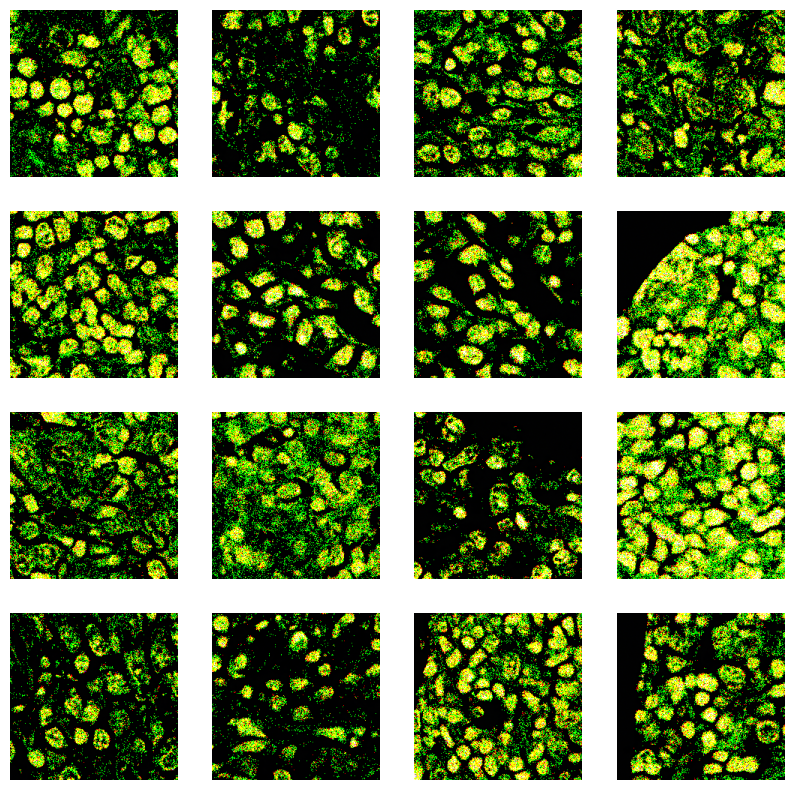

In [107]:
image_batch = next(iter(train_ds_aug))
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[0][i].numpy().astype("uint8"))
  plt.axis("off")

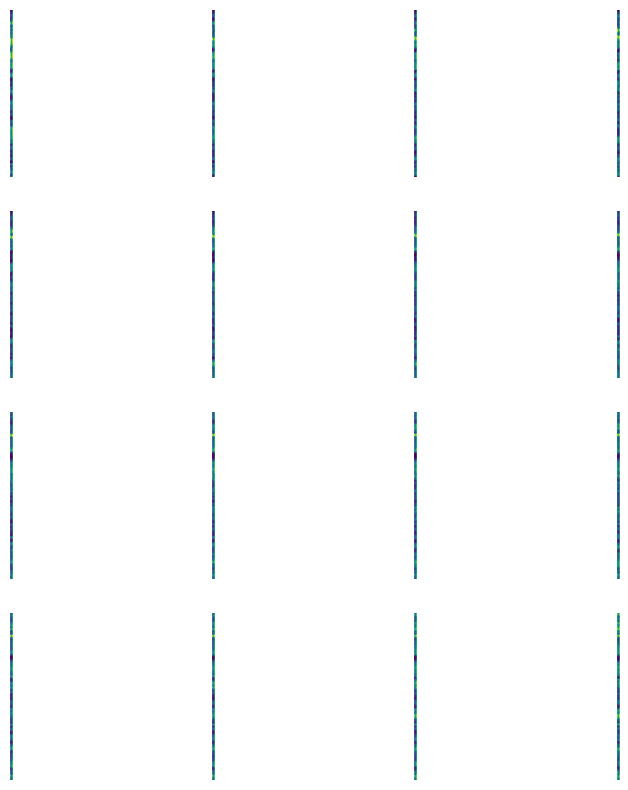

In [108]:
image_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[0][i].numpy().astype("uint8"))
  plt.axis("off")

In [44]:
x_batch = image_batch[0].numpy()
x_batch_aug = seq(images=x_batch)
#x_batch_aug = preprocess_input(x_batch_aug)

In [45]:
y_batch = image_batch[1].numpy()

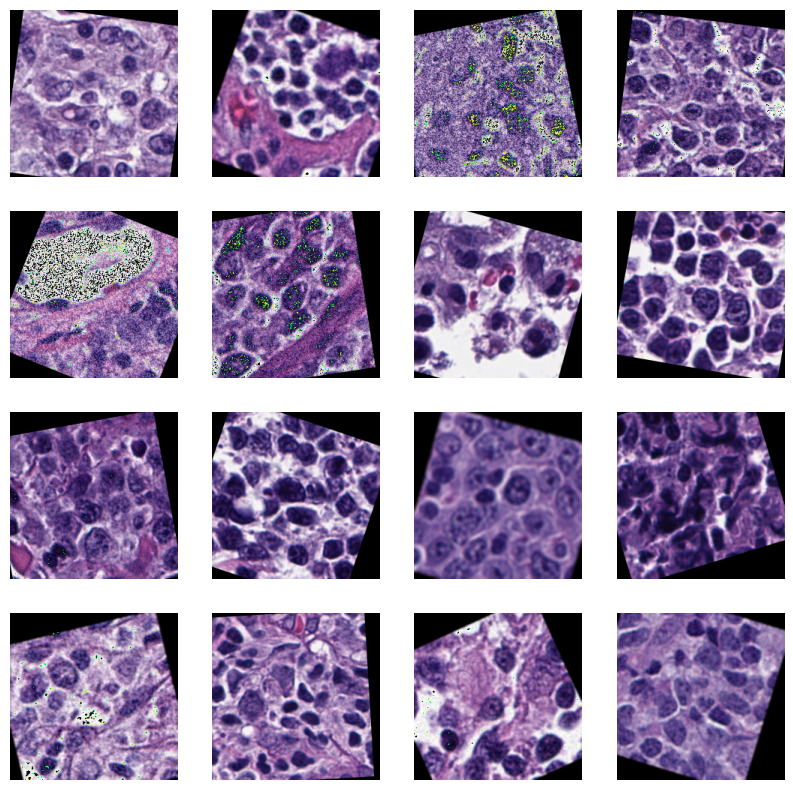

In [46]:
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(x_batch_aug[i].astype("uint8"))
  plt.axis("off")

In [90]:
import time

In [112]:
start = time.time()
autoencoder.model.train_on_batch(x_batch_aug, y_batch)
end = time.time()
print(end - start)

ResourceExhaustedError: Graph execution error:

Detected at node 'autoencoder/decoder/conv2d_transpose_2/conv2d_transpose' defined at (most recent call last):
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\julie\AppData\Local\Temp\ipykernel_10980\1051239064.py", line 2, in <module>
      autoencoder.model.train_on_batch(x_batch_aug, y_batch)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\training.py", line 2381, in train_on_batch
      logs = self.train_function(iterator)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "C:\Users\julie\miniconda3\envs\M1_project\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'autoencoder/decoder/conv2d_transpose_2/conv2d_transpose'
OOM when allocating tensor with shape[32,64,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node autoencoder/decoder/conv2d_transpose_2/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_109442]

In [17]:
x_batch_aug = next(iter(train_ds_aug))

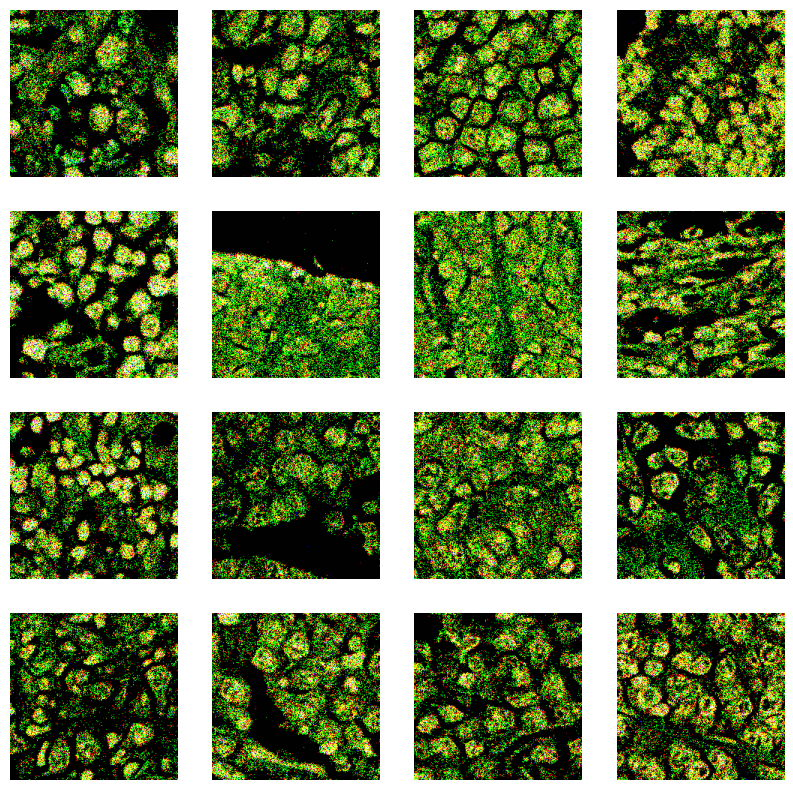

In [20]:
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(x_batch_aug[0][i].numpy().astype("uint8"))
  plt.axis("off")

In [3]:
from tensorflow import keras
model = keras.models.load_model('../models/myModel_2.4')

In [18]:
predicted_batch = model.predict(x_batch_aug[0])

1/1 [==============================] - 6s 6s/step


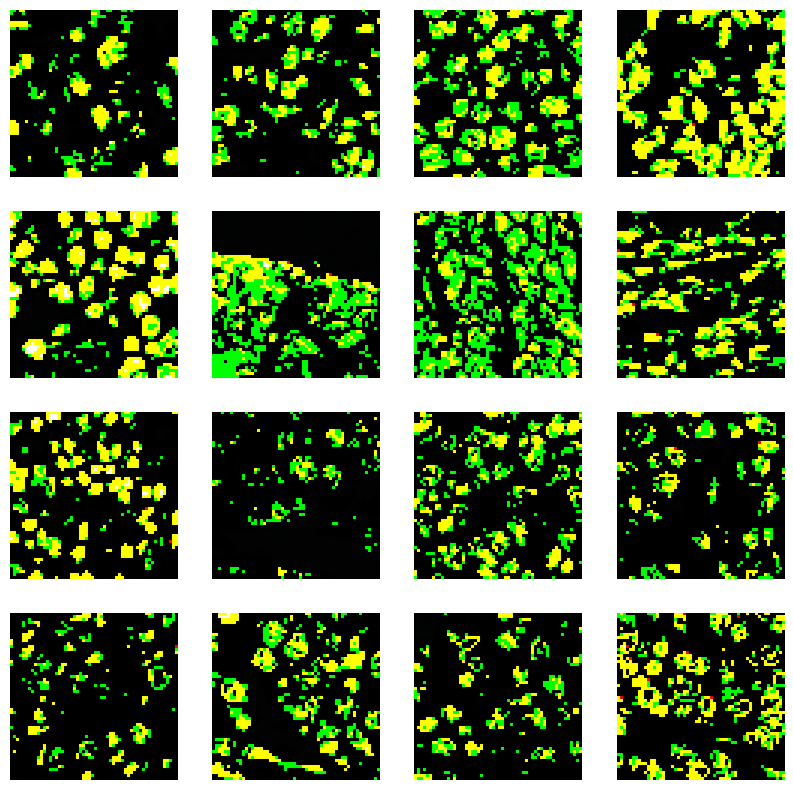

In [19]:
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(predicted_batch[i].astype("uint8"))
  plt.axis("off")